In [22]:
import sys, os
# os.environ["THEANO_FLAGS"] = "device=cuda"  # use gpu
sys.path.append("../../../")
import gempy as gp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import topology_numpy as tpn

Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Active grids: ['regular']
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cuda
Precision:  float32
Number of faults:  2
Compilation Done!


C:\Users\r02as18\miniconda3\envs\topology\lib\site-packages\theano\tensor\slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=2.46756e-12): result may not be accurate.
  rval = scipy.linalg.solve(A, b)


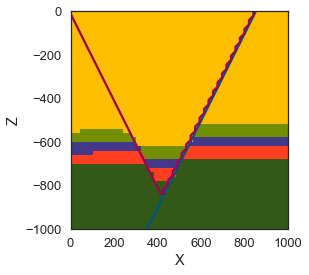

In [23]:
geo_model = gp.load_model(
    'Tutorial_ch1-9b_Fault_relations', 
    path= '../../data/gempy_models', 
    recompile=True
)
gp.compute_model(geo_model)
gp.plot.plot_section(geo_model, show_data=True)

In [24]:
res = geo_model.grid.regular_grid.resolution
lb = np.round(geo_model.solutions.block_matrix[-1, 0, :]).astype(int)
fb = np.round(geo_model.solutions.block_matrix[:-1, 0, :]).astype(int)

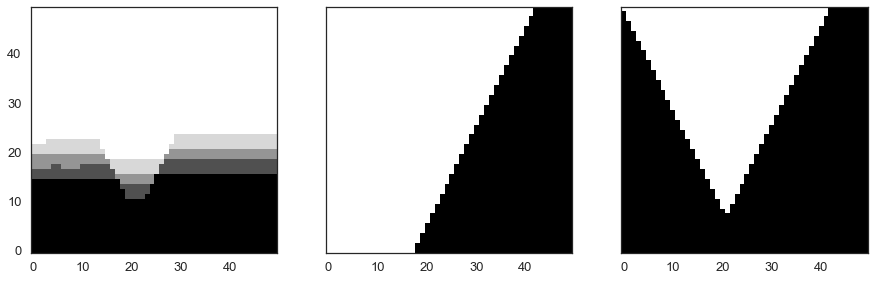

In [25]:
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(15,8))

for ax, block in zip(axs, (lb, *fb)):
    ax.imshow(block.reshape(*res)[:, 24, :].T, origin="lower")

In [26]:
geo_model.surfaces

,surface,series,order_surfaces,isBasement,color,id
7,fault2,fault_series2,1,False,#015482,1
5,fault1,fault_series1,1,False,#9f0052,2
6,rock4,series1,1,False,#ffbe00,3
0,rock3,series1,2,False,#728f02,4
3,rock2,series1,3,False,#443988,5
1,rock1,series1,4,False,#ff3f20,6
4,basement,basement_series,1,True,#325916,7


In [27]:
geo_model.faults

,isFault,isFinite
fault_series2,True,False
fault_series1,True,False
series1,False,False
basement_series,False,False


In [289]:
logging.basicConfig(level=logging.DEBUG, format='%(message)s')

In [335]:
reload(tpn)

<module 'topology_numpy' from 'C:\\Users\\r02as18\\git\\gempy\\notebooks\\experimental\\topology\\topology_numpy.py'>

fault id's: [1 2]
lb labels: [0 1 2 3 4]
fb_labels shp: (2, 125000)
fb labels: [ 5  6  8 10]
fb 0: [5 6]
fb 1: [ 8 10]
olabels (pre-sum): [ 1  2  4  8 16]
olabels (pre-sum): [32 64]
olabels (pre-sum): [ 256 1024]
ulabels: [ 289  290  292  296  304 1057 1058 1060 1064 1072 1089 1090 1092 1096
 1104]
n labels: 15
sum_x shp: (49, 50, 50)
sum_y shp: (50, 49, 50)
sum_z shp: (50, 50, 49)
slx slice(0, -1, None); sly slice(0, -1, None); slz slice(0, -1, None)
(3, 49, 49, 49)


Uniquely labeled all geobodies: True


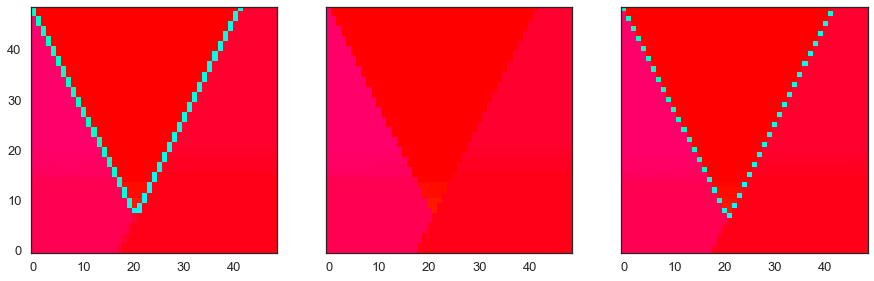

In [423]:
logger.setLevel(logging.DEBUG)

labels, olabels = tpn.get_labels_block(geo_model)
ulabels = np.unique(labels)
print("Uniquely labeled all geobodies:", len(np.unique(labels)) == 15)
sum_xyz = tpn.get_topo_block(labels, n_shift=1)

fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(15,8))

for ax, img in zip(axs, sum_xyz):
    ax.imshow(img[:, 24, :].T, origin="lower", cmap="hsv")

In [424]:
for label in ulabels:
    binary = np.binary_repr(label)
    print(binary, "->", int(binary, 2))

100100001 -> 289
100100010 -> 290
100100100 -> 292
100101000 -> 296
100110000 -> 304
10000100001 -> 1057
10000100010 -> 1058
10000100100 -> 1060
10000101000 -> 1064
10000110000 -> 1072
10001000001 -> 1089
10001000010 -> 1090
10001000100 -> 1092
10001001000 -> 1096
10001010000 -> 1104


In [425]:
for label in np.unique(sum_xyz[2]):
    binary = np.binary_repr(label)
    print(binary, "->", int(binary, 2))

1001000010 -> 578
1001000011 -> 579
1001000100 -> 580
1001000110 -> 582
1001001000 -> 584
1001001100 -> 588
1001010000 -> 592
1001011000 -> 600
1001100000 -> 608
10101000010 -> 1346
10101000011 -> 1347
10101000101 -> 1349
10101001010 -> 1354
10101010100 -> 1364
10101011000 -> 1368
10101100000 -> 1376
10101100010 -> 1378
10101100011 -> 1379
10101100101 -> 1381
10101101010 -> 1386
10101110010 -> 1394
10101110100 -> 1396
10101111000 -> 1400
10110000000 -> 1408
100001000010 -> 2114
100001000011 -> 2115
100001000100 -> 2116
100001000110 -> 2118
100001001000 -> 2120
100001001100 -> 2124
100001010000 -> 2128
100001011000 -> 2136
100001100000 -> 2144
100010000000 -> 2176
100010000010 -> 2178
100010000011 -> 2179
100010000100 -> 2180
100010000110 -> 2182
100010001000 -> 2184
100010001100 -> 2188
100010010000 -> 2192
100010011000 -> 2200
100010100000 -> 2208


In [426]:
logger = logging.getLogger()

In [427]:
from copy import copy

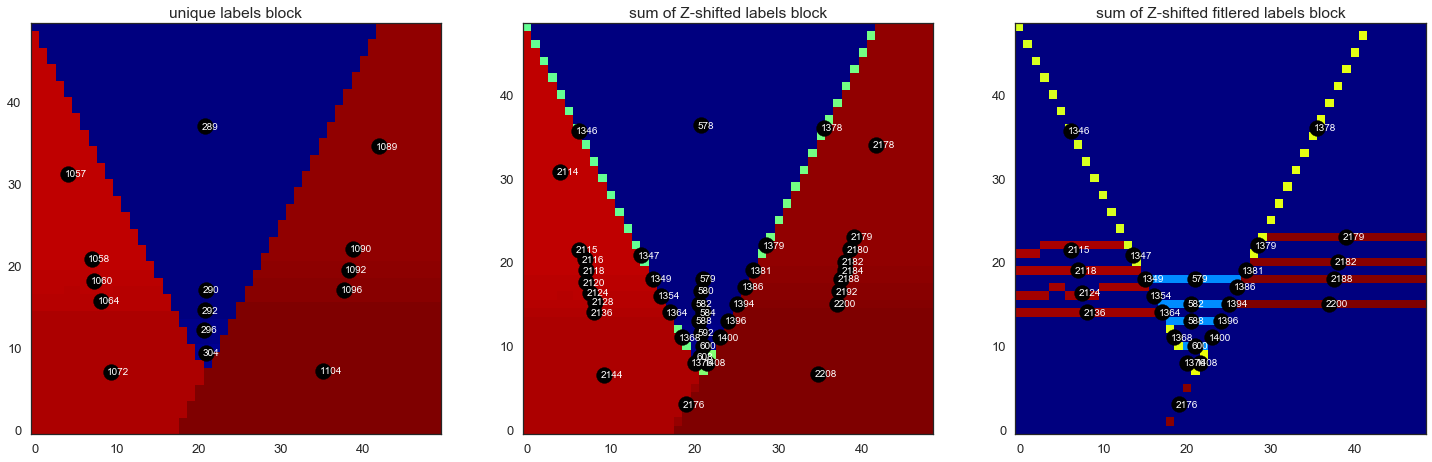

In [428]:
logger.setLevel(logging.CRITICAL)


topo_block = copy(sum_xyz[2])
diff_ctrs = tpn.get_centroids(topo_block, np.unique(topo_block))

topo_block_filtered = copy(sum_xyz[2])
topo_block_filtered[np.isin(topo_block_filtered, 2*np.unique(labels))] = 0
diff_ctrs_filtered = tpn.get_centroids(topo_block_filtered, np.unique(topo_block_filtered))

fig, axs = plt.subplots(figsize=(25,10), ncols=3)

labels_ctrs = get_centroids(labels, np.unique(labels))
ax = axs[0]
for k, v in labels_ctrs.items():
    ax.scatter(v[0], v[2], c="k", s=250)
    ax.text(v[0]-0.4, v[2]-0.3, str(k), c="w")
ax.set_title("unique labels block")
ax.imshow(labels[:, 24, :].T, origin="lower", cmap="jet")

ax = axs[1]
for k, v in diff_ctrs.items():
    if k == 0:
        continue
    ax.scatter(v[0], v[2], c="k", s=250)
    ax.text(v[0]-0.4, v[2]-0.3, str(k), c="w")
ax.set_title("sum of Z-shifted labels block")
ax.imshow(topo_block[:, 24, :].T, origin="lower", cmap="jet")

ax = axs[2]
for k, v in diff_ctrs_filtered.items():
    if k == 0:
        continue
    ax.scatter(v[0], v[2], c="k", s=250)
    ax.text(v[0]-0.4, v[2]-0.3, str(k), c="w")
ax.set_title("sum of Z-shifted fitlered labels block")
ax.imshow(topo_block_filtered[:, 24, :].T, origin="lower", cmap="jet")

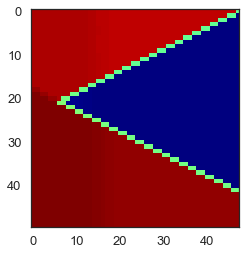

In [416]:
plt.imshow((labels[:, 24, 2:] + labels[:, 24, :-2]), cmap="jet")

In [394]:
ulabel_LOT[1349]

(292, 1057)

Is the next bug is in the creation of the LOT? But the sums in it are correct, its just that the sums are done for units that are not actually connected. E.g. instead of summing `1060 + 290 = 1350`, its summing `1057 + 290 = 1347` at the wrong position. Can this be a bug related to the shifting and cropping?

In [397]:
1057 + 290

1347

In [372]:
sum_of_nodes = np.unique(ulabels)
sum_of_nodes

array([ 289,  290,  292,  296,  304, 1057, 1058, 1060, 1064, 1072, 1089,
       1090, 1092, 1096, 1104], dtype=int64)

In [373]:
ulabel_LOT = tpn.get_node_label_sum_lot(sum_of_nodes)

possible node combinations: [(289, 290), (289, 292), (289, 296), (289, 304), (289, 1057), (289, 1058), (289, 1060), (289, 1064), (289, 1072), (289, 1089), (289, 1090), (289, 1092), (289, 1096), (289, 1104), (290, 292), (290, 296), (290, 304), (290, 1057), (290, 1058), (290, 1060), (290, 1064), (290, 1072), (290, 1089), (290, 1090), (290, 1092), (290, 1096), (290, 1104), (292, 296), (292, 304), (292, 1057), (292, 1058), (292, 1060), (292, 1064), (292, 1072), (292, 1089), (292, 1090), (292, 1092), (292, 1096), (292, 1104), (296, 304), (296, 1057), (296, 1058), (296, 1060), (296, 1064), (296, 1072), (296, 1089), (296, 1090), (296, 1092), (296, 1096), (296, 1104), (304, 1057), (304, 1058), (304, 1060), (304, 1064), (304, 1072), (304, 1089), (304, 1090), (304, 1092), (304, 1096), (304, 1104), (1057, 1058), (1057, 1060), (1057, 1064), (1057, 1072), (1057, 1089), (1057, 1090), (1057, 1092), (1057, 1096), (1057, 1104), (1058, 1060), (1058, 1064), (1058, 1072), (1058, 1089), (1058, 1090), (1058

In [374]:
np.unique(topo_block)

array([ 578,  579,  580,  582,  584,  588,  592,  600,  608, 1346, 1347,
       1349, 1354, 1364, 1368, 1376, 1378, 1379, 1381, 1386, 1394, 1396,
       1400, 1408, 2114, 2115, 2116, 2118, 2120, 2124, 2128, 2136, 2144,
       2176, 2178, 2179, 2180, 2182, 2184, 2188, 2192, 2200, 2208],
      dtype=int64)

In [377]:
from importlib import reload
reload(tpn)

<module 'topology_numpy' from 'C:\\Users\\r02as18\\git\\gempy\\notebooks\\experimental\\topology\\topology_numpy.py'>

In [378]:
logger.setLevel(logging.DEBUG)
edges = tpn.get_edges(topo_block_filtered, ulabel_LOT)
edges

Invalid edge: 0
Valid edge: (289, 290)
Valid edge: (290, 292)
Valid edge: (292, 296)
Valid edge: (296, 304)
Valid edge: (289, 1057)
Valid edge: (290, 1057)
Valid edge: (292, 1057)
Valid edge: (296, 1058)
Valid edge: (304, 1060)
Valid edge: (304, 1064)
Valid edge: (304, 1072)
Valid edge: (289, 1089)
Valid edge: (290, 1089)
Valid edge: (292, 1089)
Valid edge: (296, 1090)
Valid edge: (304, 1090)
Valid edge: (304, 1092)
Valid edge: (304, 1096)
Valid edge: (304, 1104)
Valid edge: (1057, 1058)
Valid edge: (1058, 1060)
Valid edge: (1060, 1064)
Valid edge: (1064, 1072)
Valid edge: (1072, 1104)
Valid edge: (1089, 1090)
Valid edge: (1090, 1092)
Valid edge: (1092, 1096)
Valid edge: (1096, 1104)


[(289, 290),
 (290, 292),
 (292, 296),
 (296, 304),
 (289, 1057),
 (290, 1057),
 (292, 1057),
 (296, 1058),
 (304, 1060),
 (304, 1064),
 (304, 1072),
 (289, 1089),
 (290, 1089),
 (292, 1089),
 (296, 1090),
 (304, 1090),
 (304, 1092),
 (304, 1096),
 (304, 1104),
 (1057, 1058),
 (1058, 1060),
 (1060, 1064),
 (1064, 1072),
 (1072, 1104),
 (1089, 1090),
 (1090, 1092),
 (1092, 1096),
 (1096, 1104)]

In [385]:
centroids = get_centroids(labels, ulabels)

289: [20.74193548 24.5        36.96296296]
290: [20.83333333 24.5        17.06666667]
292: [20.73333333 24.5        14.53333333]
296: [20.66666667 24.5        12.13333333]
304: [20.83333333 24.5         9.33333333]
1057: [ 4.05621302 24.3590448  31.13461538]
1058: [ 6.92161254 25.24692049 20.76819709]
1060: [ 7.2020202  24.17508418 18.10630111]
1064: [ 8.05530188 24.84271943 15.70624049]
1072: [ 9.23024055 24.5         7.        ]
1089: [42.  24.5 34.5]
1090: [38.828125 24.5      21.984375]
1092: [38.24444444 24.5        19.48888889]
1096: [37.66197183 24.5        16.98591549]
1104: [35.15789474 24.5         7.13157895]


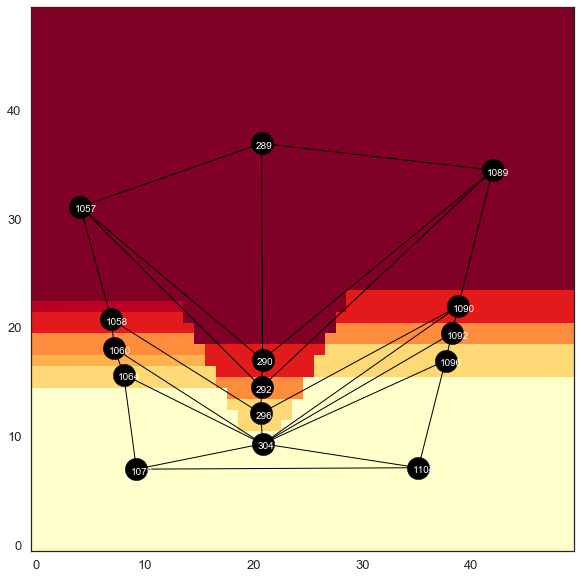

In [390]:
fig = plt.figure(figsize=(10,10))
plt.imshow(geo_model.solutions.block_matrix[-1].reshape(50,50, 50)[:, 24, :].T, origin="lower", cmap="YlOrRd_r")

for edge in edges:
    e1, e2 = edge
    p1 = centroids.get(e1)
    p2 = centroids.get(e2)
    x = (p1[0], p2[0])
    y = (p1[2], p2[2])
    plt.plot(x, y, c="k", linewidth=1)
    
for node in ulabels:
    p = centroids.get(node)
    plt.scatter(p[0], p[2], c="k", s=500)
    plt.text(p[0]-0.5, p[2]-0.5, str(node), c="w")

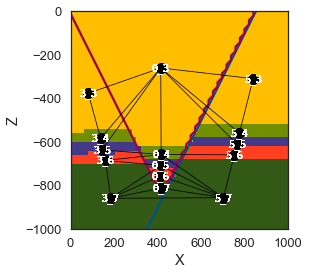

In [391]:
from gempy.assets import topology as tp
G, c = tp.compute_topology(geo_model, filter_rogue=True)
gp.plot.plot_section(geo_model, 24)
gp.plot.plot_topology(geo_model, G, c)